In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indathon-round1-2024/jumlah_penumpang_mrt.csv
/kaggle/input/indathon-round1-2024/jumlah_perjalanan_mrt.csv
/kaggle/input/indathon-round1-2024/training_jumlah_penumpang_tj.csv
/kaggle/input/indathon-round1-2024/testing_jumlah_penumpang_tj.csv
/kaggle/input/indathon-round1-2024/jumlah_perjalanan_lrt.csv
/kaggle/input/indathon-round1-2024/sample_submision.csv
/kaggle/input/indathon-round1-2024/jumlah_armada_tj.csv
/kaggle/input/indathon-round1-2024/jumlah_penumpang_lrt.csv
/kaggle/input/indathon/regressor.csv


In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.6f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from math import sqrt

!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.linear_model import LinearRegression
# from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import pickle
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.9 MB/s eta 0:00:0000:0100:01


In [3]:
! python --version

Python 3.10.13


In [65]:
import importlib

# List of modules to check
modules = [
    'numpy', 'pandas', 'matplotlib', 'seaborn', 'datetime', 'math', 'prophet', 
    'sklearn', 'warnings', 'pmdarima', 'statmodels','pickle'
]

def get_module_version(module_name):
    try:
        module = importlib.import_module(module_name)
        version = getattr(module, '__version__', 'unknown')
    except AttributeError:
        version = 'unknown'
    except ImportError:
        version = 'not installed'
    return version

print("Libraries Used:")
for module in modules:
    version = get_module_version(module)
    print(f"{module}: {version}")


Libraries Used:
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.7.5
seaborn: 0.12.2
datetime: unknown
math: unknown
prophet: 1.1.1
sklearn: 1.2.2
warnings: unknown
pmdarima: 2.0.4
statmodels: not installed
pickle: unknown


# PREPARATION

## Import Data

In [5]:
df_train = pd.read_csv('/kaggle/input/indathon-round1-2024/training_jumlah_penumpang_tj.csv', sep=';')
df_test = pd.read_csv('/kaggle/input/indathon-round1-2024/testing_jumlah_penumpang_tj.csv', sep=';')

In [6]:
df_train['year'] = df_train['tahun']
df_train['month'] = df_train['bulan']
df_train['dt'] = pd.to_datetime(df_train.assign(day=1)[['year', 'month', 'day']]) + pd.offsets.MonthEnd(0)

df_train.drop(['bulan','tahun','year','month'], axis =1, inplace = True)
df_train = df_train.set_index('dt')
df_train.head()

,jumlah_penumpang
dt,
2015-01-31,8738599
2015-02-28,7630313
2015-03-31,9383835
2015-04-30,8832441
2015-05-31,9035420


In [7]:
df_train.index

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31',
               ...
               '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30',
               '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31',
               '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', name='dt', length=108, freq=None)

## Train & Test

Train data : (96, 1)
Test data : (12, 1)


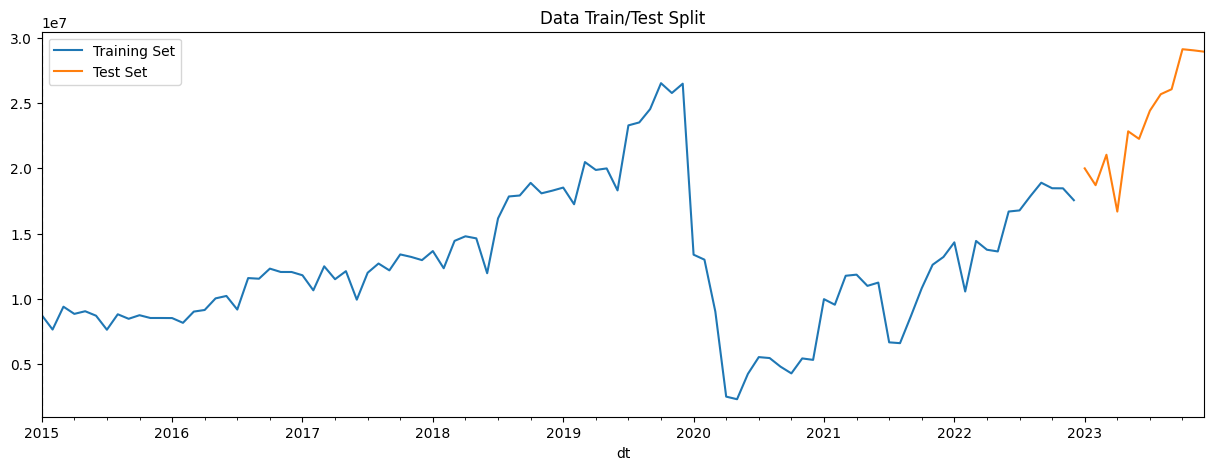

In [8]:
train = df_train.loc[df_train.index < '2023-01-01']
test = df_train.loc[df_train.index >= '2023-01-01']


print("Train data : " + str(train.shape))
print("Test data : " + str(test.shape))

fig, ax = plt.subplots(figsize=(15, 5))
train['jumlah_penumpang'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['jumlah_penumpang'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Feature Extraction

In [9]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    
    X = df[['quarter','month','year']]
    if label:
        y = df[label]
        return X, y
    return X


In [10]:
Xtrain, Ytrain = create_features(train, 'jumlah_penumpang')
Xtrain['jumlah_penumpang'] = Ytrain
Xtrain.head(2)

,quarter,month,year,jumlah_penumpang
dt,,,,
2015-01-31,1,1,2015,8738599
2015-02-28,1,2,2015,7630313


In [11]:

Xtest, Ytest = create_features(test, 'jumlah_penumpang')
Xtest['jumlah_penumpang'] = Ytest
Xtest.head(2)

,quarter,month,year,jumlah_penumpang
dt,,,,
2023-01-31,1,1,2023,20001303
2023-02-28,1,2,2023,18710281


## Visualization

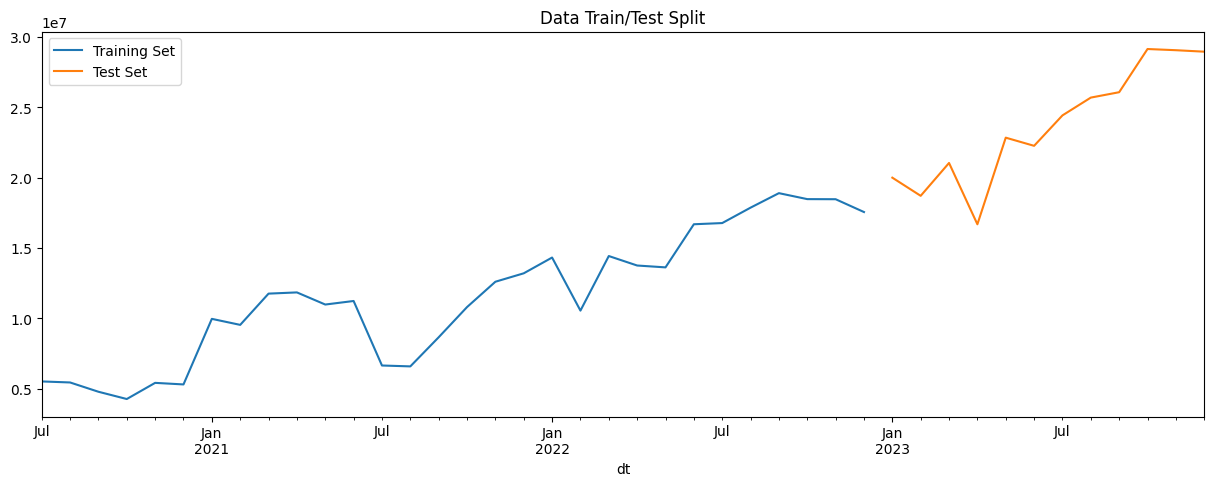

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
train.loc[train.index >= '2020-07-01']['jumlah_penumpang'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['jumlah_penumpang'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

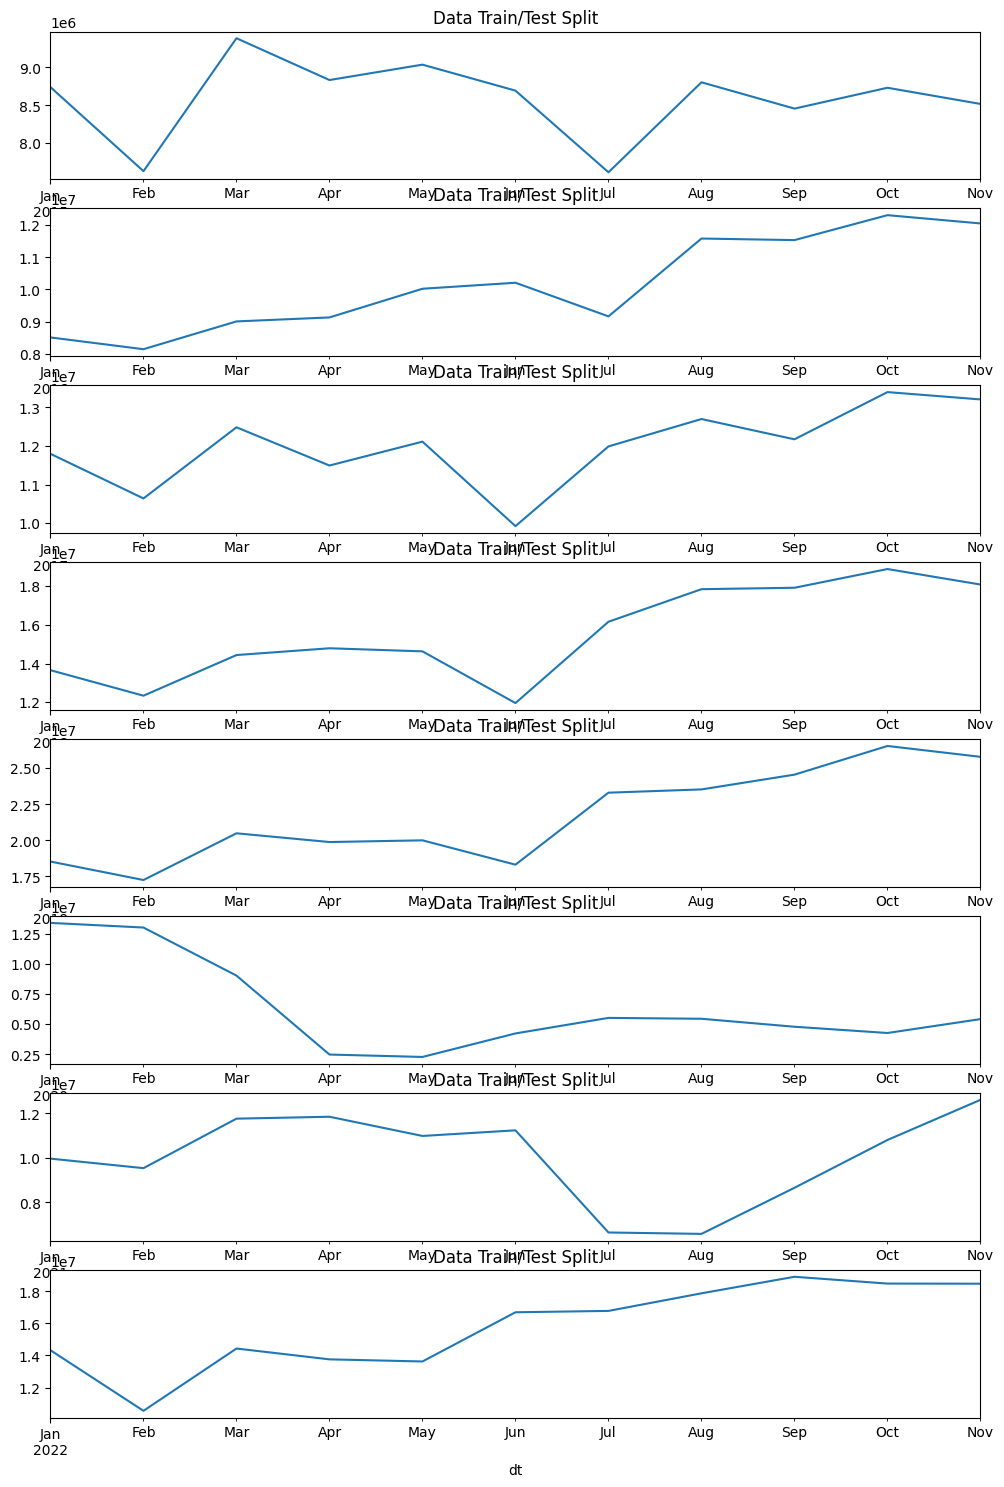

In [13]:
# Plot the decomposed components
plt.figure(figsize=(12, 18))

plt.subplot(811)
train.loc[(train.index >= '2015-01-01') & (train.index <= '2015-12-01')]['jumlah_penumpang'].plot(label='Training Set', title='Data Train/Test Split')
# ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.subplot(812)
train.loc[(train.index >= '2016-01-01') & (train.index <= '2016-12-01')]['jumlah_penumpang'].plot(label='Training Set', title='Data Train/Test Split')
# ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.subplot(813)
train.loc[(train.index >= '2017-01-01') & (train.index <= '2017-12-01')]['jumlah_penumpang'].plot(label='Training Set', title='Data Train/Test Split')
# ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.subplot(814)
train.loc[(train.index >= '2018-01-01') & (train.index <= '2018-12-01')]['jumlah_penumpang'].plot( label='Training Set', title='Data Train/Test Split')
# ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.subplot(815)
train.loc[(train.index >= '2019-01-01') & (train.index <= '2019-12-01')]['jumlah_penumpang'].plot( label='Training Set', title='Data Train/Test Split')
# ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.subplot(816)
train.loc[(train.index >= '2020-01-01') & (train.index <= '2020-12-01')]['jumlah_penumpang'].plot(label='Training Set', title='Data Train/Test Split')
# ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.subplot(817)
train.loc[(train.index >= '2021-01-01') & (train.index <= '2021-12-01')]['jumlah_penumpang'].plot( label='Training Set', title='Data Train/Test Split')
# ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.subplot(818)
train.loc[(train.index >= '2022-01-01') & (train.index <= '2022-12-01')]['jumlah_penumpang'].plot( label='Training Set', title='Data Train/Test Split')
# ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.show()

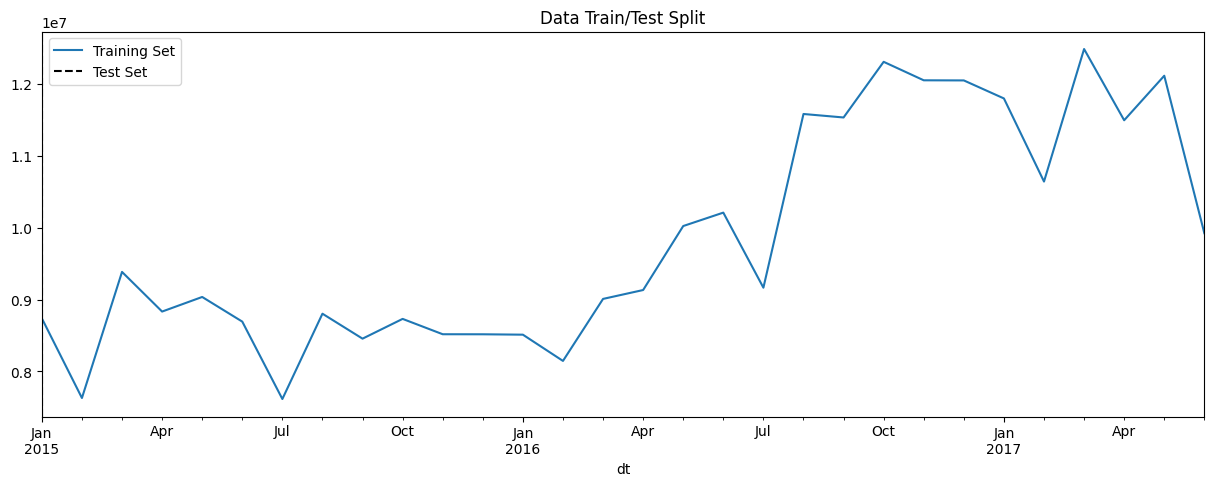

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
train.loc[train.index < '2017-07-01']['jumlah_penumpang'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
# test['jumlah_penumpang'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Seasonal Decompose

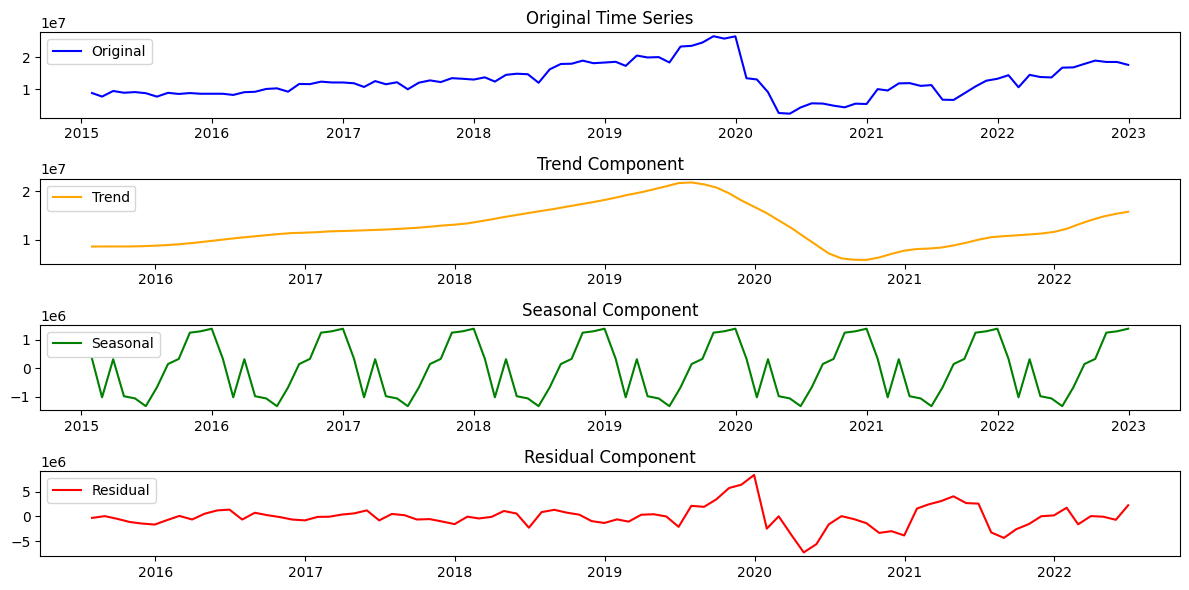

In [15]:
result = seasonal_decompose(train['jumlah_penumpang'], model='additive', period=12)

# Plot the decomposed components
plt.figure(figsize=(12, 6))

plt.subplot(411)
plt.plot(train['jumlah_penumpang'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

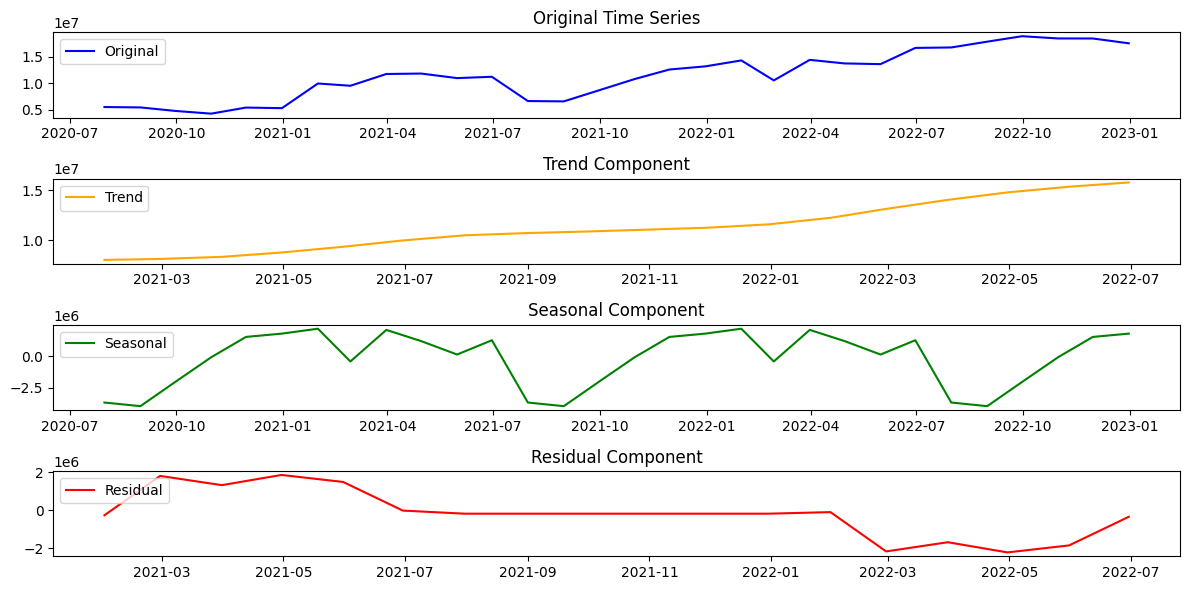

In [16]:
result = seasonal_decompose(train.loc[train.index >= '2020-07-01']['jumlah_penumpang'], model='additive', period=12)

# Plot the decomposed components
plt.figure(figsize=(12, 6))

plt.subplot(411)
plt.plot(train.loc[train.index >= '2020-07-01']['jumlah_penumpang'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

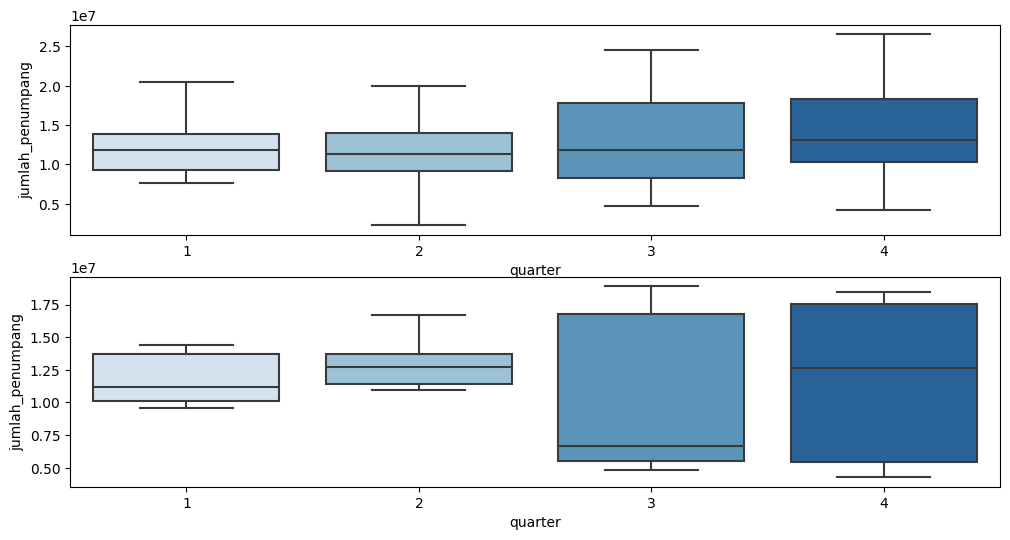

In [17]:
# Plot the decomposed components
plt.figure(figsize=(12, 6))

plt.subplot(211)
sns.boxplot(data=Xtrain, x='quarter', y='jumlah_penumpang', palette='Blues')
ax.set_title('MW by Month')
# plt.show()

plt.subplot(212)
sns.boxplot(data=Xtrain.loc[train.index >= '2020-07-01'], x='quarter', y='jumlah_penumpang', palette='Blues')
ax.set_title('MW by Month')
plt.show()

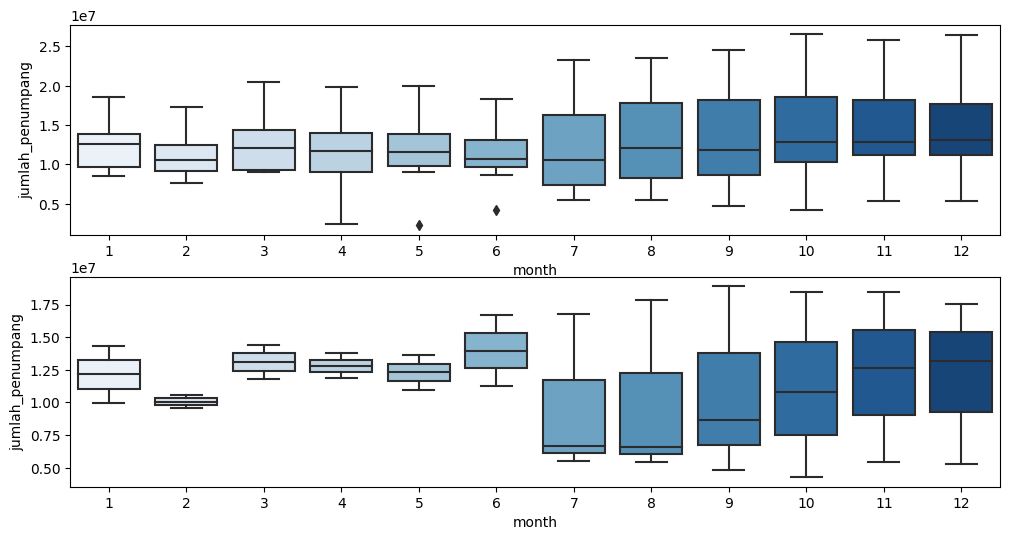

In [18]:
# Plot the decomposed components
plt.figure(figsize=(12, 6))

plt.subplot(211)
sns.boxplot(data=Xtrain, x='month', y='jumlah_penumpang', palette='Blues')
ax.set_title('MW by Month')
# plt.show()

plt.subplot(212)
sns.boxplot(data=Xtrain.loc[train.index >= '2020-07-01'], x='month', y='jumlah_penumpang', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# MODELLING

# PROPHET

## Prophet + changepoint_prior_scale + Add Regressor

In [19]:
# Prepare the data for Prophet
df = pd.DataFrame({'ds': train.index, 'y': train.jumlah_penumpang})
df2 = df.loc[df.index > '2020-06-30']
df2.head()

,ds,y
dt,,
2020-07-31,2020-07-31,5515000
2020-08-31,2020-08-31,5442000
2020-09-30,2020-09-30,4782000
2020-10-31,2020-10-31,4265000
2020-11-30,2020-11-30,5414000


**Regressor**
* Juli - Agustus 2021 : Level 4
* 8 Februari 2022 :  PPKM Level 3.
* 22 November s.d. 5 Desember 2022
* maret 2020 - Juni 2023 covid 

In [20]:
regressor = pd.read_csv('/kaggle/input/indathon/regressor.csv', sep=';')
regressor['dt'] = pd.to_datetime(regressor['dt'], format='%d/%m/%Y') + pd.offsets.MonthEnd(0)
regressor = regressor.set_index('dt').fillna(0)

regressor['keb_ppkm4'] = 0
regressor.loc[['2021-07-31','2021-08-31'],'keb_ppkm4'] = 1

regressor['keb_ppkm3'] = 0
regressor.loc[['2022-02-28'],'keb_ppkm3'] = 1

regressor['keb_ppkm_mikro'] = 0
regressor.loc[['2021-02-28','2021-03-31','2021-04-30','2021-05-31'],'keb_ppkm_mikro'] = 1

regressor['awal_covid'] = 0
regressor.loc[['2020-01-31','2020-02-29','2020-03-31','2020-04-30','2020-05-31','2020-06-30'],'awal_covid'] = 1

regressor['pandemi'] = 0
regressor.loc[(regressor.index >= '2020-01-01'), 'pandemi'] = 1

regressor['after_pandemi'] = 0
regressor.loc[(regressor.index >= '2023-07-01'), 'after_pandemi'] = 1


regressor.tail(12)

,cuti bersama,idul_fitri,cuti_idul_fitri,ramadhan,libur_sekolah,jumlah_libur,keb_ppkm4,keb_ppkm3,keb_ppkm_mikro,awal_covid,pandemi,after_pandemi
dt,,,,,,,,,,,,
2024-01-31,0,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,0,0,1,1
2024-02-29,0,0.000000,0.000000,0.000000,0.000000,3.000000,0,0,0,0,1,1
2024-03-31,0,0.000000,0.000000,1.000000,0.000000,4.000000,0,0,0,0,1,1
2024-04-30,8-15,1.000000,1.000000,1.000000,0.000000,6.000000,0,0,0,0,1,1
2024-05-31,0,0.000000,0.000000,0.000000,0.000000,6.000000,0,0,0,0,1,1
2024-06-30,0,0.000000,0.000000,0.000000,1.000000,3.000000,0,0,0,0,1,1
2024-07-31,0,0.000000,0.000000,0.000000,1.000000,1.000000,0,0,0,0,1,1
2024-08-31,0,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,0,0,1,1
2024-09-30,0,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,0,0,1,1


In [21]:
# df[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi']]
# future[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi']]
df[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']]


14:03:11 - cmdstanpy - INFO - Chain [1] start processing
14:03:12 - cmdstanpy - INFO - Chain [1] done processing


               yhat
102 22081830.922769
103 22514939.077906
104 23141505.594527
105 24385096.217804
106 24156890.740350
107 24567808.593075


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


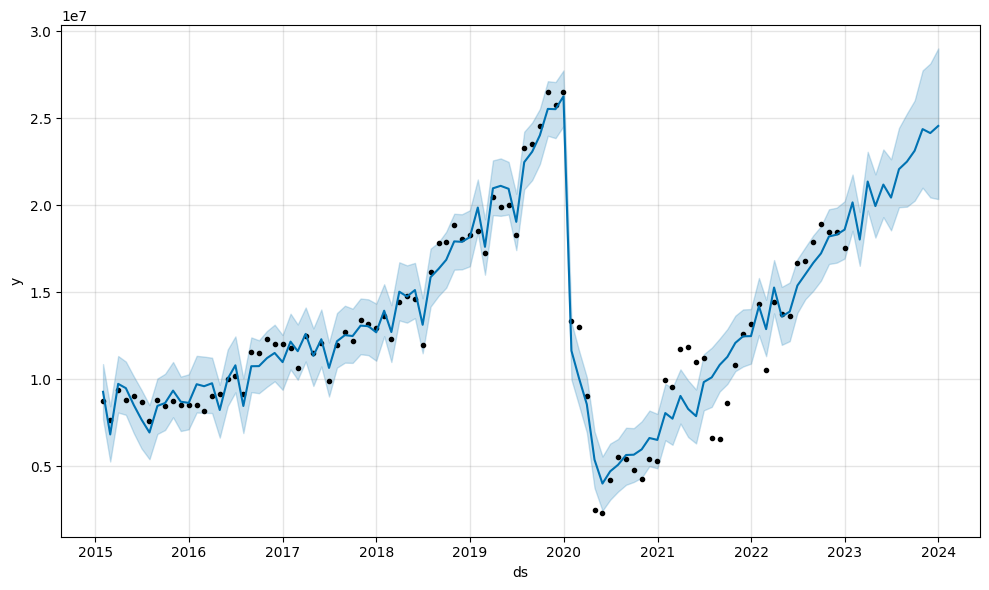

In [22]:

prophet_regressor = Prophet(changepoint_prior_scale=0.8)
# prophet_regressor.add_regressor('idul_fitri').add_regressor('jumlah_libur') #.add_regressor('libur_sekolah').add_regressor('keb_ppkm4').add_regressor('keb_ppkm3').add_regressor('keb_ppkm_mikro')#.add_regressor('jumlah_libur')#.add_regressor('awal_covid').add_regressor('cuti_idul_fitri')#.add_regressor('jumlah_libur').add_regressor('jumlah_libur')#.add_regressor('pandemi')
prophet_regressor.add_regressor('cuti_idul_fitri').add_regressor('libur_sekolah').add_regressor('jumlah_libur').add_regressor('awal_covid').add_regressor('pandemi').add_regressor('after_pandemi')#.add_regressor('keb_ppkm4').add_regressor('keb_ppkm3').add_regressor('keb_ppkm_mikro')

prophet_regressor.fit(df)
future = prophet_regressor.make_future_dataframe(periods=12, freq='ME')
future = future.set_index('ds')
future[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']]
future = future.reset_index()

future.loc[future.ds == '2024-01-31','libur_sekolah'] = 1
forecast = prophet_regressor.predict(future)
print(forecast.tail(6)[['yhat']])
fig = prophet_regressor.plot(forecast)

In [23]:
print('Print MSE Train Data : ' + str(mean_squared_error(forecast.iloc[:-12].yhat, train.jumlah_penumpang)))
print('Print MSE Test Data : ' + str(mean_squared_error(forecast.tail(12).yhat, test.jumlah_penumpang)))

print('Print RMSE Train Data : ' + str(sqrt(mean_squared_error(forecast.iloc[:-12].yhat, train.jumlah_penumpang))))
print('Print RMSE Test Data : ' + str(sqrt(mean_squared_error(forecast.tail(12).yhat, test.jumlah_penumpang))))
print('Print RMSE Test Data [Jan - Jul]: ' + str(sqrt(mean_squared_error(forecast.tail(12).yhat[:6], test.jumlah_penumpang[:6]))))
print('Print RMSE Test Data [Agt - Dec]:  ' + str(sqrt(mean_squared_error(forecast.tail(12).yhat[-6:], test.jumlah_penumpang[-6:]))))


Print MSE Train Data : 1573493264638.6545
Print MSE Test Data : 8962311543025.633
Print RMSE Train Data : 1254389.5984257262
Print RMSE Test Data : 2993712.000681701
Print RMSE Test Data [Jan - Jul]: 1698911.8854033542
Print RMSE Test Data [Agt - Dec]:  3877927.4737527627


## Prophet Prediction

In [24]:
df_final = pd.DataFrame()
df_final['y'] = df_train['jumlah_penumpang']
df_final['ds'] = df_train.index
df_final[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']]


14:03:14 - cmdstanpy - INFO - Chain [1] start processing
14:03:14 - cmdstanpy - INFO - Chain [1] done processing


               yhat
108 30040433.375510
109 29537240.544067
110 30094397.858978
111 27082272.627501
112 30967905.519770
113 31701640.591503


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


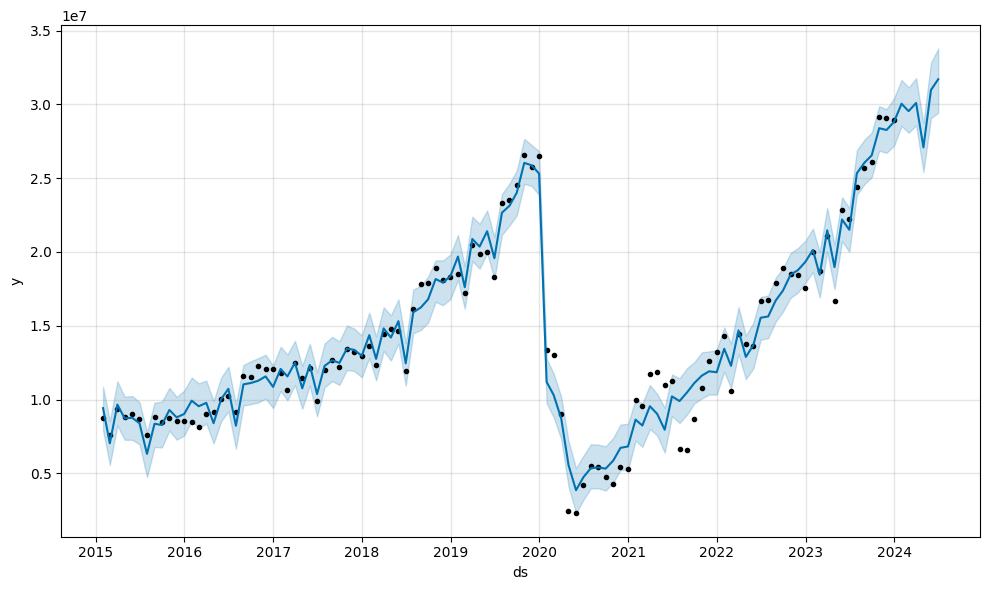

In [25]:
prophet_regressor = Prophet(changepoint_prior_scale=0.8)
# prophet_regressor.add_regressor('idul_fitri').add_regressor('jumlah_libur') #.add_regressor('libur_sekolah').add_regressor('keb_ppkm4').add_regressor('keb_ppkm3').add_regressor('keb_ppkm_mikro')#.add_regressor('jumlah_libur')#.add_regressor('awal_covid').add_regressor('cuti_idul_fitri')#.add_regressor('jumlah_libur').add_regressor('jumlah_libur')#.add_regressor('pandemi')
prophet_regressor.add_regressor('cuti_idul_fitri').add_regressor('libur_sekolah').add_regressor('jumlah_libur').add_regressor('awal_covid').add_regressor('pandemi').add_regressor('after_pandemi')#.add_regressor('keb_ppkm4').add_regressor('keb_ppkm3').add_regressor('keb_ppkm_mikro')
prophet_regressor.fit(df_final)
future = prophet_regressor.make_future_dataframe(periods=6, freq='ME')
future = future.set_index('ds')
future[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']]
future = future.reset_index()


future.loc[future.ds == '2024-01-31','libur_sekolah'] = 1
forecast = prophet_regressor.predict(future)
print(forecast.tail(6)[['yhat']])
fig = prophet_regressor.plot(forecast)

In [26]:
forecast.tail(6)[['yhat']].reset_index(drop=True)#.to_csv('sub_prophet.csv')

,yhat
0,30040433.375510
1,29537240.544067
2,30094397.858978
3,27082272.627501
4,30967905.519770
5,31701640.591503


In [27]:
# save model
# with open('prophet_regressor.pkl', 'wb') as file:
#     pickle.dump(prophet_regressor, file)

In [28]:
# def read_pickle(file):
#     with open(file, 'rb') as file:
#         model = pickle.load(file)

#     return model

# def prepare_regressor(file):
#     regressor = pd.read_csv(file, sep=';')
#     regressor['dt'] = pd.to_datetime(regressor['dt'], format='%d/%m/%Y') + pd.offsets.MonthEnd(0)
#     regressor = regressor.set_index('dt').fillna(0)

#     regressor['keb_ppkm4'] = 0
#     regressor.loc[['2021-07-31','2021-08-31'],'keb_ppkm4'] = 1

#     regressor['keb_ppkm3'] = 0
#     regressor.loc[['2022-02-28'],'keb_ppkm3'] = 1

#     regressor['keb_ppkm_mikro'] = 0
#     regressor.loc[['2021-02-28','2021-03-31','2021-04-30','2021-05-31'],'keb_ppkm_mikro'] = 1

#     regressor['awal_covid'] = 0
#     regressor.loc[['2020-01-31','2020-02-29','2020-03-31','2020-04-30','2020-05-31','2020-06-30'],'awal_covid'] = 1

#     regressor['pandemi'] = 0
#     regressor.loc[(regressor.index >= '2020-01-01'), 'pandemi'] = 1

#     regressor['after_pandemi'] = 0
#     regressor.loc[(regressor.index >= '2023-07-01'), 'after_pandemi'] = 1

#     return regressor

# def predict(model, regressor):
#     future = model.make_future_dataframe(periods=6, freq='ME')
#     future = future.set_index('ds')
#     future[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']]
#     future = future.reset_index()

#     future.loc[future.ds == '2024-01-31','libur_sekolah'] = 1
#     forecast = model.predict(future)
    
#     return(forecast)


## RUNNING FUNCTION ##

# file_pickle = '/kaggle/working/prophet_regressor.pkl'
# file_regressor = '/kaggle/input/indathon/regressor.csv'
# model = read_pickle(file_pickle)
# regressor = prepare_regressor(file_regressor)
# print('++ read file done ++')


# forecast = predict(model, regressor)
# print('++ forecaasting done ++')
# print(forecast.yhat[-6:])

# SARIMAX

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
Y_arima = df_train['jumlah_penumpang']
Y_arima.tail(2)

dt
2023-11-30    29062581
2023-12-31    28957580
Name: jumlah_penumpang, dtype: int64

In [31]:
X_arima = regressor.copy()
X_arima = X_arima[['cuti_idul_fitri','libur_sekolah','jumlah_libur','awal_covid','pandemi','after_pandemi']]
X_arima = X_arima.loc[X_arima.index < '2024-01-01']
X_arima.tail(2)

,cuti_idul_fitri,libur_sekolah,jumlah_libur,awal_covid,pandemi,after_pandemi
dt,,,,,,
2023-11-30,0.000000,0.000000,0.000000,0,1,1
2023-12-31,0.000000,1.000000,2.000000,0,1,1


In [32]:
model = auto_arima(Y_arima, exogenous=X_arima, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)
print(model.summary())

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3437.934, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3439.892, Time=0.10 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3441.842, Time=0.30 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3439.894, Time=0.11 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3441.888, Time=0.29 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3443.841, Time=1.33 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3441.835, Time=0.22 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3443.835, Time=0.61 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=3445.825, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3438.209, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3440.208, Time=0.14 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3442.168, Time=0.32 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3440.208, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3442.199, Time=0.38 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3444.161, Time=0.80

In [33]:
n_periods = 6
X_arima_future = regressor.loc[regressor.index > '2024-01-01']
forecast = model.predict(n_periods=n_periods, exogenous=X_arima_future)
print(forecast)

2024-01-31   29319588.500640
2024-02-29   29259734.100477
2024-03-31   29450846.052482
2024-04-30   29641958.004487
2024-05-31   29833069.956492
2024-06-30   30024181.908498
Freq: ME, dtype: float64


/tmp/ipykernel_33/3162792700.py:5: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=Y_arima.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='m')


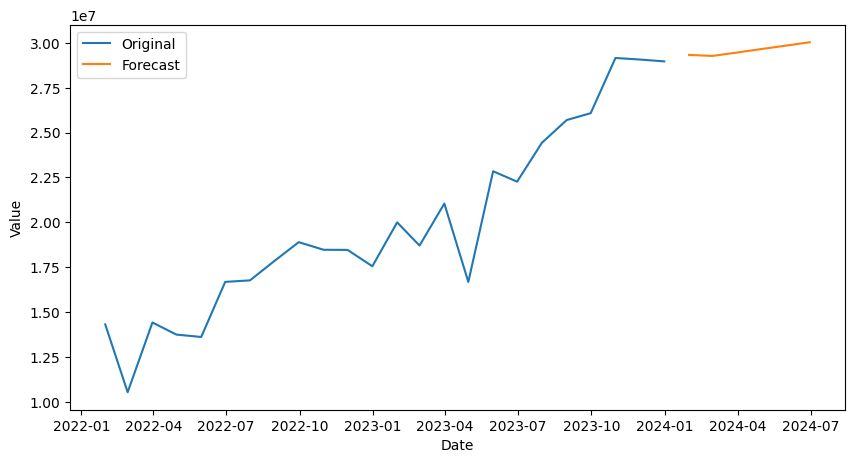

In [34]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(Y_arima.index[-24:], Y_arima[-24:], label='Original')

forecast_dates = pd.date_range(start=Y_arima.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='m')
plt.plot(forecast_dates, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# UTILIZE AUX DATA

In [35]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indathon-round1-2024/jumlah_penumpang_mrt.csv
/kaggle/input/indathon-round1-2024/jumlah_perjalanan_mrt.csv
/kaggle/input/indathon-round1-2024/training_jumlah_penumpang_tj.csv
/kaggle/input/indathon-round1-2024/testing_jumlah_penumpang_tj.csv
/kaggle/input/indathon-round1-2024/jumlah_perjalanan_lrt.csv
/kaggle/input/indathon-round1-2024/sample_submision.csv
/kaggle/input/indathon-round1-2024/jumlah_armada_tj.csv
/kaggle/input/indathon-round1-2024/jumlah_penumpang_lrt.csv
/kaggle/input/indathon/regressor.csv


In [36]:
df_jumlah_penumpang_mrt = pd.read_csv('/kaggle/input/indathon-round1-2024/jumlah_penumpang_mrt.csv', sep=';')
df_jumlah_penumpang_mrt['jumlah_penumpang_mrt'] = df_jumlah_penumpang_mrt['jumlah_penumpang'] 
df_jumlah_penumpang_mrt.drop('jumlah_penumpang',axis=1, inplace=True) 
print(df_jumlah_penumpang_mrt.head(2))
print(df_jumlah_penumpang_mrt.tail(2))

   bulan  tahun  jumlah_penumpang_mrt
0      1   2023               2540315
1      2   2023               2378568
    bulan  tahun  jumlah_penumpang_mrt
15      4   2024               2607904
16      5   2024               3175772


In [37]:
df_jumlah_perjalanan_mrt = pd.read_csv('/kaggle/input/indathon-round1-2024/jumlah_perjalanan_mrt.csv', sep=';')
df_jumlah_perjalanan_mrt['jumlah_perjalanan_mrt'] = df_jumlah_perjalanan_mrt['jumlah_perjalanan']
df_jumlah_perjalanan_mrt.drop('jumlah_perjalanan',axis=1, inplace=True)
print(df_jumlah_perjalanan_mrt.head(2))
print(df_jumlah_perjalanan_mrt.tail(2))

   bulan  tahun  jumlah_perjalanan_mrt
0      1   2023                   8035
1      2   2023                   7340
    bulan  tahun  jumlah_perjalanan_mrt
15      4   2024                   7626
16      5   2024                   7882


In [38]:
df_jumlah_penumpang_lrt = pd.read_csv('/kaggle/input/indathon-round1-2024/jumlah_penumpang_lrt.csv', sep=';')
df_jumlah_penumpang_lrt['jumlah_penumpang_lrt'] = df_jumlah_penumpang_lrt['jumlah_penumpang']
df_jumlah_penumpang_lrt.drop('jumlah_penumpang', axis=1, inplace=True)
print(df_jumlah_penumpang_lrt.head(2))
print(df_jumlah_penumpang_lrt.tail(2))

   bulan  tahun  jumlah_penumpang_lrt
0      1   2023                 72424
1      2   2023                 76166
    bulan  tahun  jumlah_penumpang_lrt
15      4   2024                 84571
16      5   2024                 96550


In [39]:
df_jumlah_perjalanan_lrt = pd.read_csv('/kaggle/input/indathon-round1-2024/jumlah_perjalanan_lrt.csv', sep=';')
df_jumlah_perjalanan_lrt['jumlah_perjalanan_lrt'] = df_jumlah_perjalanan_lrt['jumlah_perjalanan']
df_jumlah_perjalanan_lrt.drop('jumlah_perjalanan', axis=1, inplace=True)
print(df_jumlah_perjalanan_lrt.head(2))
print(df_jumlah_perjalanan_lrt.tail(2))

   bulan  tahun  jumlah_perjalanan_lrt
0      1   2023                   6190
1      2   2023                   5980
    bulan  tahun  jumlah_perjalanan_lrt
15      4   2024                   6120
16      5   2024                   6324


In [40]:
df_jumlah_armada_tj = pd.read_csv('/kaggle/input/indathon-round1-2024/jumlah_armada_tj.csv', sep=';')
print(df_jumlah_armada_tj.head(2))
print(df_jumlah_armada_tj.tail(2))

   bulan  tahun  jumlah_armada_tj
0      1   2023              3853
1      2   2023              3864
    bulan  tahun  jumlah_armada_tj
15      4   2024              4457
16      5   2024              4409


In [41]:
df_aux = df_jumlah_penumpang_mrt.merge(df_jumlah_perjalanan_mrt).merge(df_jumlah_penumpang_lrt).merge(df_jumlah_perjalanan_lrt).merge(df_jumlah_armada_tj)
df_aux.head(2)

,bulan,tahun,jumlah_penumpang_mrt,jumlah_perjalanan_mrt,jumlah_penumpang_lrt,jumlah_perjalanan_lrt,jumlah_armada_tj
0,1,2023,2540315,8035,72424,6190,3853
1,2,2023,2378568,7340,76166,5980,3864


In [42]:
df_aux['year'] = df_aux['tahun']
df_aux['month'] = df_aux['bulan']
df_aux['dt'] = pd.to_datetime(df_aux.assign(day=1)[['year', 'month', 'day']]) + pd.offsets.MonthEnd(0)

df_aux.drop(['bulan','tahun','year','month'], axis =1, inplace = True)
df_aux = df_aux.set_index('dt')
# df_aux.head()

df_pred = df_aux.iloc[12:,:].join(regressor, how='left')#.join(df_train, how='left')
df_aux = df_aux.iloc[:12,:].join(df_train, how='left').join(regressor, how='left')
df_aux.head(2)

,jumlah_penumpang_mrt,jumlah_perjalanan_mrt,jumlah_penumpang_lrt,jumlah_perjalanan_lrt,jumlah_armada_tj,jumlah_penumpang,cuti bersama,idul_fitri,cuti_idul_fitri,ramadhan,libur_sekolah,jumlah_libur,keb_ppkm4,keb_ppkm3,keb_ppkm_mikro,awal_covid,pandemi,after_pandemi
dt,,,,,,,,,,,,,,,,,,
2023-01-31,2540315,8035,72424,6190,3853,20001303,0,0.000000,0.000000,0.000000,0.000000,3.000000,0,0,0,0,1,0
2023-02-28,2378568,7340,76166,5980,3864,18710281,0,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,0,0,1,0


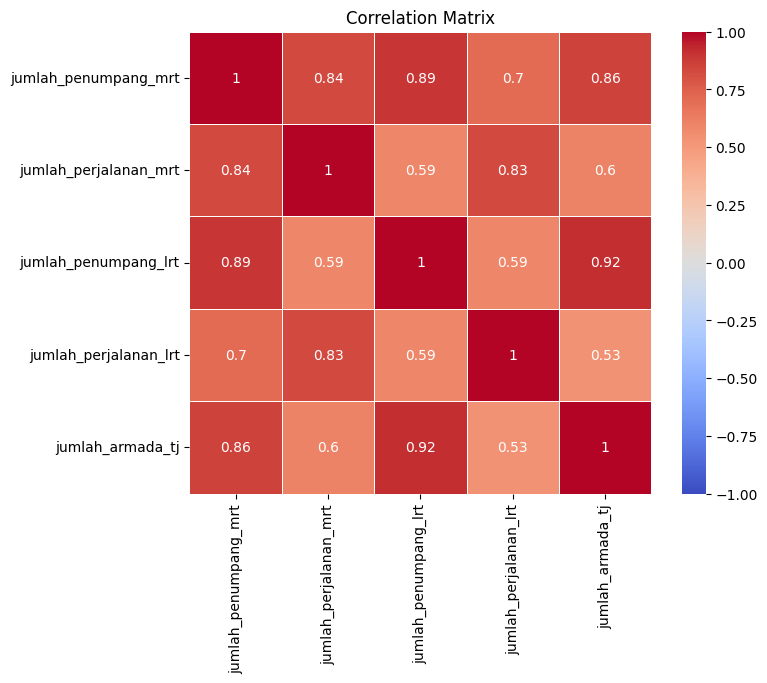

In [43]:
corr = df_aux.iloc[:,:5].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)

plt.title('Correlation Matrix')
plt.show()

## LinReg & Prophet

In [44]:
y = df_aux['jumlah_penumpang'].values.reshape(-1, 1)
X = df_aux[['jumlah_penumpang_lrt','jumlah_perjalanan_lrt', 'jumlah_armada_tj','cuti_idul_fitri','ramadhan','libur_sekolah','after_pandemi']].values
model = LinearRegression()
model.fit(X, y)

forecast = model.predict(df_pred[['jumlah_penumpang_lrt','jumlah_perjalanan_lrt', 'jumlah_armada_tj','cuti_idul_fitri','ramadhan','libur_sekolah','after_pandemi']])
forecast

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([[30926753.78053914],
       [28242209.82685392],
       [29817705.51144926],
       [26586194.40691258],
       [31646575.83457041]])

In [45]:
df_for_corr = pd.DataFrame(forecast, columns=['jumlah_penumpang'])
# df_for_corr.to_csv('linreg_result.csv')
print(df_for_corr)

   jumlah_penumpang
0   30926753.780539
1   28242209.826854
2   29817705.511449
3   26586194.406913
4   31646575.834570


In [46]:
# # 
# future = prophet_regressor.make_future_dataframe(periods=6, freq='ME')

In [47]:
df_final2 = df_final.copy()
future = future.set_index('ds')
future['ds'] = future.index
df_final2 = pd.concat([df_final2,future.iloc[-6:,:]])
df_final2.loc[(df_final2.index>'2024-01-01') & (df_final2.index<'2024-06-01'),'y'] = df_for_corr.jumlah_penumpang.values
df_final2

,y,ds,idul_fitri,cuti_idul_fitri,libur_sekolah,jumlah_libur,keb_ppkm4,keb_ppkm3,keb_ppkm_mikro,pandemi,awal_covid,after_pandemi
2015-01-31,8738599.000000,2015-01-31,0.000000,0.000000,1.000000,2.000000,0,0,0,0,0,0
2015-02-28,7630313.000000,2015-02-28,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0,0
2015-03-31,9383835.000000,2015-03-31,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0,0
2015-04-30,8832441.000000,2015-04-30,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0,0
2015-05-31,9035420.000000,2015-05-31,0.000000,0.000000,0.000000,3.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,28242209.826854,2024-02-29,0.000000,0.000000,0.000000,3.000000,0,0,0,1,0,1
2024-03-31,29817705.511449,2024-03-31,0.000000,0.000000,0.000000,4.000000,0,0,0,1,0,1
2024-04-30,26586194.406913,2024-04-30,1.000000,1.000000,0.000000,6.000000,0,0,0,1,0,1
2024-05-31,31646575.834570,2024-05-31,0.000000,0.000000,0.000000,6.000000,0,0,0,1,0,1


14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:03 - cmdstanpy - INFO - Chain [1] done processing


               yhat
108 29518048.639389
109 28840001.535684
110 29780382.878572
111 26858667.866976
112 31271998.213809
113 32061351.787579


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


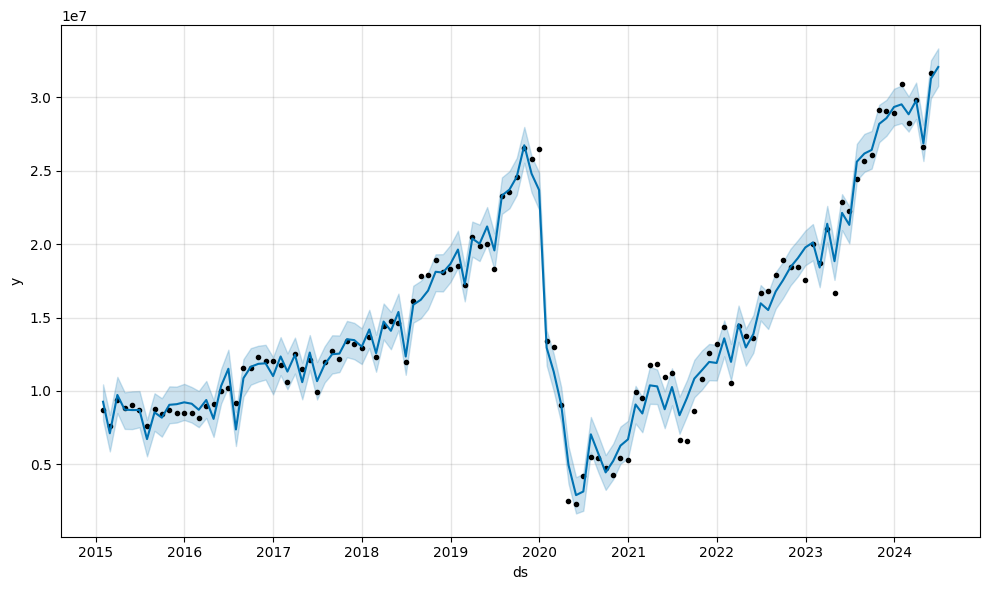

In [48]:
prophet_regressor = Prophet(changepoint_prior_scale=0.8)
# prophet_regressor.add_regressor('idul_fitri').add_regressor('libur_sekolah').add_regressor('jumlah_libur').add_regressor('awal_covid').add_regressor('pandemi').add_regressor('after_pandemi')#.add_regressor('keb_ppkm4').add_regressor('keb_ppkm3').add_regressor('keb_ppkm_mikro')
# prophet_regressor.add_regressor('libur_sekolah').add_regressor('jumlah_libur').add_regressor('cuti_idul_fitri').add_regressor('awal_covid').add_regressor('pandemi').add_regressor('after_pandemi')
prophet_regressor.add_regressor('libur_sekolah').add_regressor('jumlah_libur').add_regressor('cuti_idul_fitri').add_regressor('awal_covid').add_regressor('after_pandemi')
prophet_regressor.fit(df_final2.iloc[:-1,:])
future = prophet_regressor.make_future_dataframe(periods=1, freq='ME')

future = future.set_index('ds')
future[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']]
future = future.reset_index()

future.loc[future.ds == '2024-01-31','libur_sekolah'] = 1
forecast = prophet_regressor.predict(future)
print(forecast.tail(6)[['yhat']])
fig = prophet_regressor.plot(forecast)

In [49]:
print('Print MSE Train Data : ' + str(mean_squared_error(forecast.yhat[:-1], df_final2.iloc[:-1,:].y)))
print('Print RMSE Train Data : ' + str(sqrt(mean_squared_error(forecast.yhat[:-1], df_final2.iloc[:-1,:].y))))

Print MSE Train Data : 946861087755.459
Print RMSE Train Data : 973067.8741770581


In [50]:
# save model
with open('linreg_prophet_regressor.pkl', 'wb') as file:
    pickle.dump(prophet_regressor, file)

## Prophet - Prophet

In [51]:
df_prophet21 = df_aux[['jumlah_penumpang','jumlah_penumpang_mrt','jumlah_perjalanan_mrt',\
                       'jumlah_penumpang_lrt','jumlah_perjalanan_lrt', 'jumlah_armada_tj',\
                       'cuti_idul_fitri','idul_fitri','ramadhan','libur_sekolah','after_pandemi','jumlah_libur']]
df_prophet21 = df_prophet21.reset_index().rename(columns={"dt":"ds", "jumlah_penumpang":"y"})
df_prophet21

,ds,y,jumlah_penumpang_mrt,jumlah_perjalanan_mrt,jumlah_penumpang_lrt,jumlah_perjalanan_lrt,jumlah_armada_tj,cuti_idul_fitri,idul_fitri,ramadhan,libur_sekolah,after_pandemi,jumlah_libur
0,2023-01-31,20001303,2540315,8035,72424,6190,3853,0.000000,0.000000,0.000000,0.000000,0,3.000000
1,2023-02-28,18710281,2378568,7340,76166,5980,3864,0.000000,0.000000,0.000000,0.000000,0,1.000000
2,2023-03-31,21046680,2699585,8035,82754,6200,3890,0.000000,0.000000,1.000000,0.000000,0,2.000000
3,2023-04-30,16686971,2065546,7270,72318,5998,3853,1.000000,1.000000,1.000000,0.000000,0,7.000000
4,2023-05-31,22845144,2681876,8161,78639,6198,3944,0.000000,0.000000,0.000000,0.000000,0,2.000000
5,2023-06-30,22264954,2709731,7688,84008,6098,3980,0.000000,0.000000,0.000000,1.000000,0,4.000000
6,2023-07-31,24428349,2959449,8109,86574,6322,4114,0.000000,0.000000,0.000000,1.000000,1,1.000000
7,2023-08-31,25693459,2999724,8253,87476,6322,4090,0.000000,0.000000,0.000000,0.000000,1,1.000000
8,2023-09-30,26076085,3003191,7909,92718,6120,4136,0.000000,0.000000,0.000000,0.000000,1,1.000000
9,2023-10-31,29146729,3139371,8229,92809,6314,4261,0.000000,0.000000,0.000000,0.000000,1,0.000000


14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing


              yhat
12 31228090.106143
13 30775833.765845
14 33226089.463391
15 28135115.695314
16 33595906.686841


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


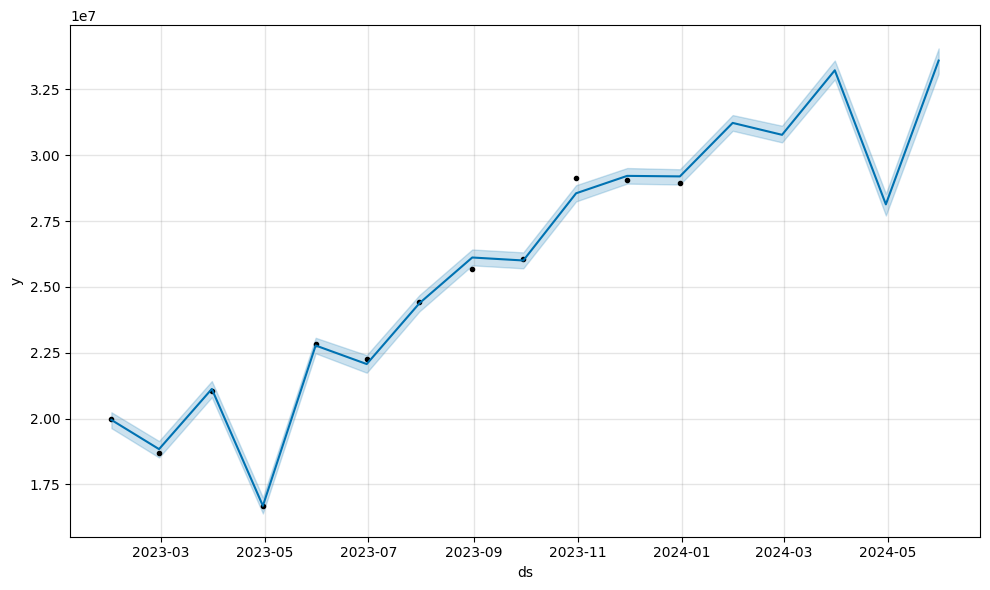

In [52]:
prophet_regressor = Prophet(changepoint_prior_scale=0.05)
prophet_regressor.add_regressor('libur_sekolah').add_regressor('cuti_idul_fitri').add_regressor('jumlah_libur') \
                    .add_regressor('jumlah_penumpang_lrt').add_regressor('jumlah_perjalanan_lrt').add_regressor('jumlah_armada_tj') \
                    
# prophet_regressor.add_regressor('jumlah_penumpang_lrt').add_regressor('jumlah_perjalanan_lrt').add_regressor('jumlah_armada_tj')
prophet_regressor.fit(df_prophet21)
future = prophet_regressor.make_future_dataframe(periods=5, freq='ME')

future = future.set_index('ds')
future[['jumlah_penumpang_mrt', 'jumlah_perjalanan_mrt', 'jumlah_penumpang_lrt','jumlah_perjalanan_lrt', 'jumlah_armada_tj',\
        'cuti_idul_fitri','idul_fitri','ramadhan','libur_sekolah','after_pandemi','jumlah_libur']] = \
        pd.concat([df_aux, df_pred])[['jumlah_penumpang_mrt', 'jumlah_perjalanan_mrt', 'jumlah_penumpang_lrt','jumlah_perjalanan_lrt', 'jumlah_armada_tj',\
        'cuti_idul_fitri','idul_fitri','ramadhan','libur_sekolah','after_pandemi','jumlah_libur']]
future = future.reset_index()

forecast = prophet_regressor.predict(future)
print(forecast.tail(5)[['yhat']])
fig = prophet_regressor.plot(forecast)

In [53]:
df_prophet22 = pd.DataFrame()
df_prophet22['y'] = df_train['jumlah_penumpang']
df_prophet22['ds'] = df_train.index
df_prophet22[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']]
df_prophet22

,y,ds,idul_fitri,cuti_idul_fitri,libur_sekolah,jumlah_libur,keb_ppkm4,keb_ppkm3,keb_ppkm_mikro,pandemi,awal_covid,after_pandemi
dt,,,,,,,,,,,,
2015-01-31,8738599,2015-01-31,0.000000,0.000000,1.000000,2.000000,0,0,0,0,0,0
2015-02-28,7630313,2015-02-28,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0,0
2015-03-31,9383835,2015-03-31,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0,0
2015-04-30,8832441,2015-04-30,0.000000,0.000000,0.000000,1.000000,0,0,0,0,0,0
2015-05-31,9035420,2015-05-31,0.000000,0.000000,0.000000,3.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,25693459,2023-08-31,0.000000,0.000000,0.000000,1.000000,0,0,0,1,0,1
2023-09-30,26076085,2023-09-30,0.000000,0.000000,0.000000,1.000000,0,0,0,1,0,1
2023-10-31,29146729,2023-10-31,0.000000,0.000000,0.000000,0.000000,0,0,0,1,0,1


14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] done processing


               yhat
108 29255211.174202
109 28798736.552029
110 29598464.703625
111 26685466.523897
112 31285941.519130
113 32132776.262586


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


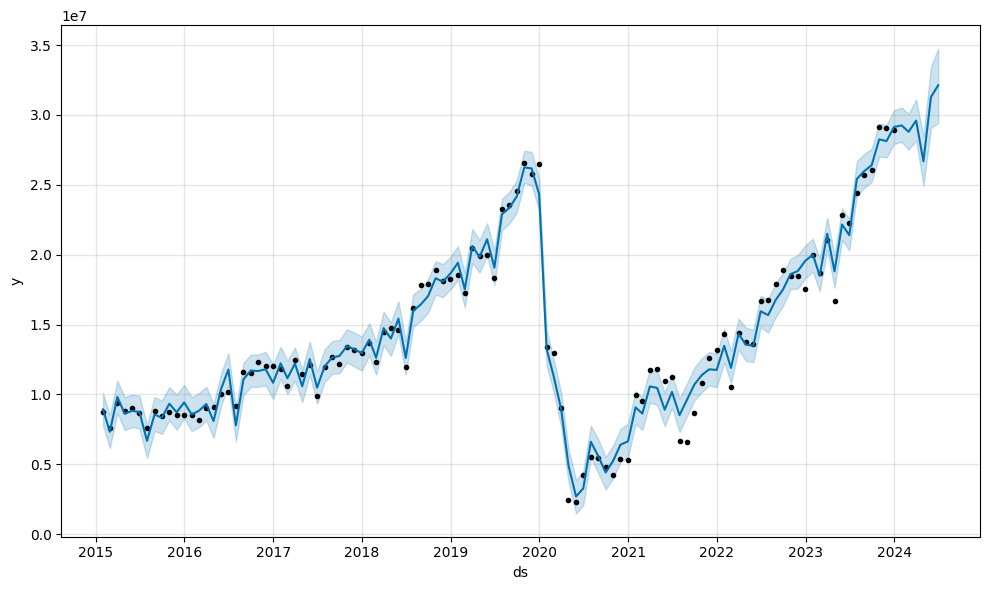

In [54]:
prophet_regressor = Prophet(changepoint_prior_scale=0.8)
# prophet_regressor.add_regressor('idul_fitri').add_regressor('libur_sekolah').add_regressor('jumlah_libur').add_regressor('awal_covid').add_regressor('pandemi').add_regressor('after_pandemi')#.add_regressor('keb_ppkm4').add_regressor('keb_ppkm3').add_regressor('keb_ppkm_mikro')
prophet_regressor.add_regressor('libur_sekolah').add_regressor('jumlah_libur').add_regressor('idul_fitri').add_regressor('awal_covid').add_regressor('after_pandemi')#.add_regressor('keb_ppkm4').add_regressor('keb_ppkm3').add_regressor('keb_ppkm_mikro')
prophet_regressor.fit(df_prophet22)
future = prophet_regressor.make_future_dataframe(periods=6, freq='ME')

future = future.set_index('ds')
future[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']] = regressor[['idul_fitri','cuti_idul_fitri','libur_sekolah','jumlah_libur','keb_ppkm4','keb_ppkm3','keb_ppkm_mikro','pandemi','awal_covid','after_pandemi']]
future = future.reset_index()

# future.loc[future.ds == '2024-01-31','libur_sekolah'] = 1
forecast = prophet_regressor.predict(future)
print(forecast.tail(6)[['yhat']])
fig = prophet_regressor.plot(forecast)

# BASE ML MODEL

In [55]:
# Xtrain['trend'] = range(1,103)
# Xtest['trend'] = range(103,109)


In [56]:

# from xgboost import XGBRegressor


In [57]:
# reg = XGBRegressor(n_estimators=1000)
# reg.fit(Xtrain.drop('jumlah_penumpang', axis=1), Ytrain,
#         eval_set=[(Xtrain.drop('jumlah_penumpang', axis=1), Ytrain), (Xtest[['quarter','month','year','trend']],Ytest)],
#         early_stopping_rounds=50,
#         verbose=False)

In [58]:
# Xtest[['quarter', 'month', 'year','trend']]

In [59]:
# Xtest = Xtest.loc[:,[x for x in Xtrain.columns]]
# Xtest['prediction'] = reg.predict(Xtest[['quarter', 'month', 'year','trend']])
# print(Xtest['prediction'])
# df_train_tmp = df_train.copy()
# df_train_tmp = df_train_tmp.merge(Xtest[['prediction']], how='left', left_index=True, right_index=True)

# ax = df_train_tmp[['jumlah_penumpang']].plot(figsize=(15, 5))
# df_train_tmp['prediction'].plot(ax=ax, style='.')
# plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Dat and Prediction')
# plt.show()

In [60]:
# Xtrain = Xtrain[['quarter','month','trend']]

In [61]:
# ! python --version

In [62]:
# reg = XGBRegressor(n_estimators=1000)
# # reg.fit(Xtrain.loc[Xtrain.index >= '2020-07-01'].drop('jumlah_penumpang', axis=1), Ytrain.loc[Ytrain.index >= '2020-07-01'],
# reg.fit(Xtrain.loc[Xtrain.index >= '2020-07-01'], Ytrain.loc[Ytrain.index >= '2020-07-01'],
#         eval_set=[(Xtrain.loc[Xtrain.index >= '2020-07-01'], Ytrain.loc[Ytrain.index >= '2020-07-01']), (Xtest[['quarter','month','trend']],Ytest)],
#         early_stopping_rounds=50,
#         verbose=False)

In [63]:
# reg.predict(Xtest[['quarter', 'month','trend']])

In [64]:
# Xtest = Xtest.loc[:,[x for x in Xtrain.columns]]
# Xtest['prediction'] = reg.predict(Xtest[['quarter', 'month','trend']])
# print(Xtest['prediction'] )
# df_train_tmp = df_train.copy()
# df_train_tmp = df_train_tmp.merge(Xtest[['prediction']], how='left', left_index=True, right_index=True)

# ax = df_train_tmp[['jumlah_penumpang']].plot(figsize=(15, 5))
# df_train_tmp['prediction'].plot(ax=ax, style='.')
# plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Dat and Prediction')
# plt.show()